# optimization for velocity pytorch

In [1]:
from lib.defaults import Main
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import json
import torch
from torch import optim
import torch.nn as nn
import sys

In [2]:
angle_i = -36
angle_f = 180. + 36
radius = 0.2
num_reach_combinations = 8 
angle = np.deg2rad(np.linspace(angle_i, angle_f, num_reach_combinations))
dt = Main().sampling_dt

# Constants
L1 = 0.3
L2 = 0.33
I1 = 0.025
I2 = 0.045
M1 = 1.4
M2 = 1.0
B11 = 0.05
B12 = 0.025
B21 = 0.025
B22 = 0.05
S1 = 0.11
S2 = 0.16
theta1 = np.deg2rad(10) # Initial theta
joint_x = L1 * np.cos(theta1)
theta2 = np.arccos(-joint_x / L2) - theta1
THETA0 = np.array([theta1, 0, theta2, 0])
np.rad2deg(theta2)

143.54438871285726

In [3]:
# position y
def hand_of(theta):
    joint_x = L1 * np.cos(theta[0])
    joint_y = L1 * np.sin(theta[0])
    joint_x_dot = -L1 * theta[1] * np.sin(theta[0])
    joint_y_dot = L1 * theta[1] * np.cos(theta[0])
    z = theta[0] + theta[2]
    zdot = theta[1] + theta[3]
    return np.array([joint_x + L2 * np.cos(z),
                     joint_y + L2 * np.sin(z),
                     joint_x_dot - L2 * zdot * np.sin(z),
                     joint_y_dot + L2 * zdot * np.cos(z)])

HAND0 = hand_of(THETA0)

In [4]:
def speed_profile(t, tau_reach):
    def bell(t):        
        t = t / tau_reach
        return t**2 * np.exp(-(t**2) / 2)
    z = bell(tau_reach * np.sqrt(2))
    return 1. / z * bell(t)

In [5]:
ca = np.cos(angle)
sa = np.sin(angle)
def straight_reach(dt, duration, radius,tau_reach):
    n_bins = int(duration / dt)
    
    def hand_traj(peak_speed):
        hand = np.zeros((n_bins, 4, num_reach_combinations))
        hand[0] = HAND0[:,None]@np.ones((1,num_reach_combinations))

        for t in range(1, n_bins):
            radial_speed = peak_speed * speed_profile(dt * t,tau_reach)
            x1_dot = ca * radial_speed
            x2_dot = sa * radial_speed
            hand[t] = np.array([hand[t-1,0,:] + dt*x1_dot, hand[t-1,1,:] + dt*x2_dot, x1_dot, x2_dot])

        return hand

    def search_peak(peak_speed):
        hand_traj_current = hand_traj(peak_speed)
        final = hand_traj_current[-1]
        achieved_radius = np.sqrt((final[0] - HAND0[0])**2 + (final[1] - HAND0[1])**2)
        return np.sum((achieved_radius - radius)**2)
    
    result = minimize(search_peak, 1.5)
    return result.x[0]

In [8]:
def generate_velocity(tau_reach,range_t,p):
    n_bins = len(range_t)
    vel = np.zeros((num_reach_combinations, 2, n_bins)) 
    vx = p *speed_profile(range_t,tau_reach)[:,None] @ ca[None,:] 
    vy = p *speed_profile(range_t,tau_reach)[:,None] @ sa[None,:]
    vel[:,0,:] = vx.T
    vel[:,1,:] = vy.T
    return vel

In [11]:
vel.shape

(8, 2, 1000)

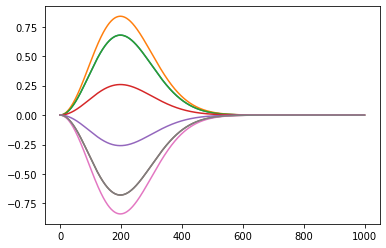

In [12]:
tau_reach = 0.14
duration = 1
velocity = []

p=straight_reach(dt, duration, radius, tau_reach)
range_t = np.arange(0,duration,dt)  

vel = generate_velocity(tau_reach,range_t,p)

plt.plot(vel[:,0,:].T)
plt.show()

In [13]:
torch.save(torch.from_numpy(vel).float(), "./velocity.pt")